In [2]:
#Reading the dataset
import pandas as pd
df=pd.read_csv('NSE_TATAGLOBAL.csv')
df.head(10)
#Sorting the data date wise
dff=df. iloc[::-1]
dff.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [3]:
#Taking High value in d1
dd=dff.reset_index()['High']
dd.head()

0    123.00
1    122.00
2    121.95
3    121.00
4    119.50
Name: High, dtype: float64

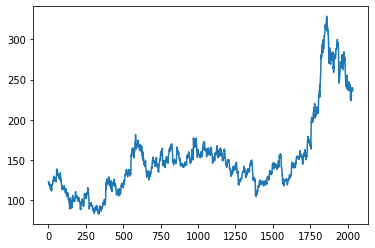

In [4]:
#Plotting Stock price w.r.t High
import matplotlib.pyplot as plt
plt.plot(dd)

In [5]:
#Applying Minmax scaler to transform values of high into 0 to 1
import numpy as np
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
dd=sc.fit_transform(np.array(dd).reshape(-1,1))
dd
#Now d1 is converted into array having value between 0 and 1

array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [6]:
#Splitting dataset into train and test split
train_size=int(len(dd)*0.65) #training size will be 65% of total size of dataset.
test_size=len(dd)-train_size #test size=35%
train_size,test_size

(1322, 713)

In [7]:
train_data,test_data=dd[0:train_size,:],dd[train_size:len(dd),:1]
len(train_data),len(test_data)

(1322, 713)

In [9]:
import numpy
# convert the array of values into a dataset matrix
def crDataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range (len(dataset)-time_step-1):
    val=dataset[i:(i+time_step),0]
    dataX.append(val)
    dataY.append(dataset[i+time_step,0])
  return numpy.array(dataX),numpy.array(dataY)

In [10]:
#reshaping into x_train and y_train
time_step=100
x_train, y_train = crDataset(train_data,time_step)
x_test, y_test =  crDataset(test_data,time_step)

In [11]:
print(x_train.shape),print(y_train.shape)

(1221, 100)
(1221,)


(None, None)

In [12]:
#reshaping x_train and x_test into three dimension which is required for LSTM.
#input be like [samples,time steps,features]
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [13]:
#Creating stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 265ms/step - loss: 0.0098 - val_loss: 0.0178
Epoch 2/100
20/20 [==============================] - 4s 213ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 3/100
20/20 [==============================] - 4s 214ms/step - loss: 9.0634e-04 - val_loss: 0.0040
Epoch 4/100
20/20 [==============================] - 4s 210ms/step - loss: 9.0668e-04 - val_loss: 0.0042
Epoch 5/100
20/20 [==============================] - 4s 206ms/step - loss: 7.9225e-04 - val_loss: 0.0037
Epoch 6/100
20/20 [==============================] - 4s 207ms/step - loss: 7.8042e-04 - val_loss: 0.0044
Epoch 7/100
20/20 [==============================] - 4s 207ms/step - loss: 7.5171e-04 - val_loss: 0.0031
Epoch 8/100
20/20 [==============================] - 4s 201ms/step - loss: 7.1129e-04 - val_loss: 0.0062
Epoch 9/100
20/20 [==============================] - 4s 207ms/step - loss: 8.1128e-04 - val_loss: 0.0055
Epoch 10/100
20/20 [==============================] - 4s 213ms

In [16]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [17]:
#Will make prediction and check performance metices
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [18]:
#Transforming back to original form
train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

In [19]:
#Calculating RSME Performance metrics
import math
from sklearn.metrics import mean_squared_error
#For train Data
math.sqrt(mean_squared_error(y_train,train_predict))

139.22618579589124

In [20]:
#For test Data
math.sqrt(mean_squared_error(y_test,test_predict))

207.2785268338642

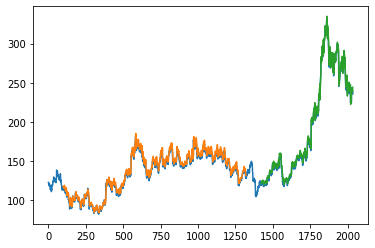

In [21]:
#plotting our train and test data
#shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(dd)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
#shift test predictions for plotting
testPredictPlot=numpy.empty_like(dd)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dd)-1,:]=test_predict
#plot baseline and predictions
plt.plot(sc.inverse_transform(dd))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
#orange--> Training data
#blue --> Original data
#green--> Predicted data

In [22]:
len(test_data)

713

In [23]:
x_input=test_data[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
#converting test data into list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
#Demonstrate prediction for the next 30 days
from numpy import array

l_output=[]
n_steps=100
i=0
while(i<30):
  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat=model.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    l_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input=x_input.reshape((1,n_steps,1)) #reshaping
    yhat=model.predict(x_input,verbose=0) #prediction
    print(yhat[0])
    temp_input.extend(yhat[0].tolist()) #adding yhat value to previous input
    print(len(temp_input))
    l_output.extend(yhat.tolist()) #adding yhat value to final output
    i=i+1

print(l_output)

[0.63614696]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 

In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131) #for 30 days prediction

In [27]:
import matplotlib.pyplot as plt
len(dd)

2035

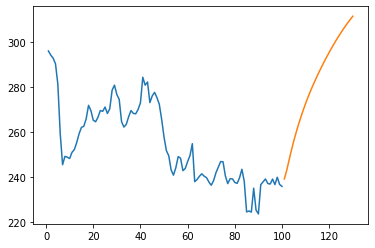

In [28]:
#Plotting the previous data and predicted data
plt.plot(day_new,sc.inverse_transform(dd[1935:]))
plt.plot(day_pred,sc.inverse_transform(l_output))

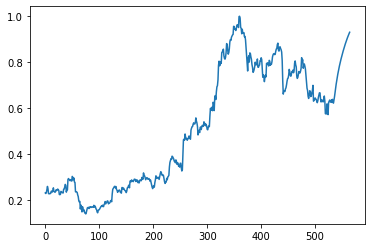

In [29]:
#Complete output of prediction.
d2=dd.tolist()
d2.extend(l_output)
plt.plot(d2[1500:])
#smooth line is our prediction